# Optimizing Resource Allocation Under Uncertainty: iFood Marketing Campaign Analysis

## Project Overview

Marketing teams routinely face the problem of allocating limited campaign resources across channels while facing substantial uncertainty in customer response. While predictive models can estimate the likelihood that a customer will accept a campaign, translating those predictions into robust allocation decisions requires explicitly accounting for uncertainty and downside risk.
This project frames marketing campaign planning as a resource allocation problem under uncertainty. Rather than optimizing a single point estimate of expected performance, the analysis evaluates how different budget allocations perform across a range of plausible response scenarios. Monte Carlo simulation and risk metrics are used to assess not only average outcomes, but also worst-case performance, enabling more robust decision-making.

## Dataset Description

The analysis uses the iFood Marketing Campaign dataset, which contains customer-level demographic information, historical purchasing behavior, and campaign response outcomes. Each row corresponds to an individual customer and includes:

- Customer attributes: age, income, household composition, education, and tenure
- Historical behavior: product spending by category, purchase counts by channel (web, catalog, store), and web visit activity
- Campaign outcome: a binary indicator of whether the customer accepted a marketing campaign (Response)

The dataset reflects a realistic marketing environment characterized by:

- Strong heterogeneity in customer behavior
- Noisy and uncertain campaign response
- Indirect measurement of campaign intensity and exposure

Importantly, the dataset does not provide explicit campaign spend by channel. As a result, campaign exposure must be modeled indirectly, which mirrors real-world situations where marketers must infer the effects of allocation decisions rather than observe them directly.

## Analytical Objective

The primary objective of this project is to answer the following question:

> How should a fixed marketing budget be allocated across channels to maximize campaign acceptance while accounting for uncertainty and downside risk?

To address this question, the analysis proceeds in four stages:

1. Campaign acceptance modeling

    Estimate how customer characteristics and campaign exposure affect the probability of campaign acceptance.

1. Uncertainty quantification

    Use bootstrap resampling to capture uncertainty in campaign effectiveness rather than relying on single point estimates.

1. Monte Carlo simulation

    Simulate campaign outcomes under thousands of plausible response scenarios for a given allocation, producing full distributions of conversions instead of single forecasts.

1. Allocation evaluation under risk

    Compare candidate allocations using expected conversions and downside risk metrics such as Conditional Value at Risk (CVaR).

This framework allows the analysis to distinguish between allocations that perform well on average and those that are robust when outcomes are unfavorable.

## Why This Approach Matters

In many marketing analytics applications, decisions are made using expected values alone. However, two allocations with similar expected performance may differ substantially in their downside risk. By explicitly modeling uncertainty and simulating outcome distributions, this project provides a decision-focused perspective that aligns more closely with how marketing leaders evaluate risk, budget stability, and robustness.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

%matplotlib inline

In [11]:
# Load raw data
df_raw = pd.read_csv("data/raw/ifood_df.csv")
df_raw.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [12]:
# Check missingness of variables
missing = df_raw.isna().mean().sort_values(ascending=False)
display(missing.head(15).to_frame("missing_rate"))

,missing_rate
Income,0.0
marital_Together,0.0
Z_Revenue,0.0
Response,0.0
Age,0.0
Customer_Days,0.0
marital_Divorced,0.0
marital_Married,0.0
marital_Single,0.0
marital_Widow,0.0


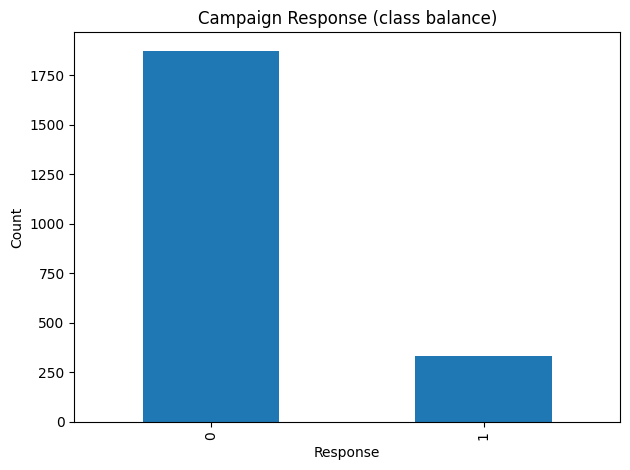

In [13]:
# Check response distribution
plt.figure()
df_raw["Response"].value_counts(dropna=False).sort_index().plot(kind="bar")
plt.title("Campaign Response (class balance)")
plt.xlabel("Response")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

> Distribution of campaign response. Only 15% of customers responded to a given campaign, and this proportion is likely noisy and unreliable.

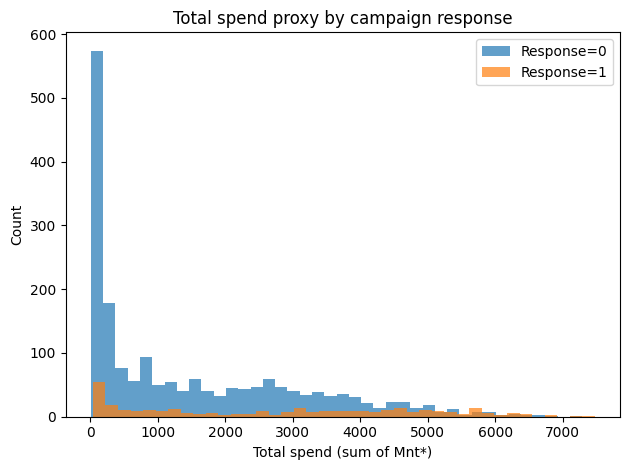

In [17]:
# Get monetary columns
mnt_cols = [c for c in df_raw.columns if c.startswith("Mnt")]

# Sum monetary columns to define total spending
total_spend = df_raw[mnt_cols].sum(axis=1)

# Plot
plt.figure()
plt.hist(total_spend[df_raw["Response"] == 0], bins=40, alpha=0.7, label="Response=0")
plt.hist(total_spend[df_raw["Response"] == 1], bins=40, alpha=0.7, label="Response=1")
plt.title("Total spend proxy by campaign response")
plt.xlabel("Total spend (sum of Mnt*)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

> A distribution of total spending stratified by campaign response does not reveal any obvious shift, suggesting that total spending is not supremely responsible for a given conversion.

In [18]:
# Fixing column names
def clean_data(df: pd.DataFrame) -> pd.DataFrame:

    # Copy original df before modifying
    out = df.copy()

    # Standardize column names
    out.columns = [c.strip().replace(" ", "_") for c in out.columns]

    # Drop duplicates
    out = out.drop_duplicates()

    # Return
    return(out)

df_clean = clean_data(df_raw)
df_clean.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n_Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


TODO: Explain augmentation decisions

In [19]:
def augment_data(df: pd.DataFrame) -> pd.DataFrame:

    # Copy original df before modifying
    out = df.copy()

    # Spend aggregates
    mnt_cols = [c for c in out.columns if c.startswith("Mnt")]
    if mnt_cols:
        out["total_spend"] = out[mnt_cols].sum(axis=1)
    else:
        out["total_spend"] = np.nan

    # Purchases aggregates (common cols in iFood dataset)
    purchase_cols = [c for c in ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"] if c in out.columns]
    if purchase_cols:
        out["total_purchases"] = out[purchase_cols].sum(axis=1)
    else:
        out["total_purchases"] = np.nan

    # Channel shares
    if set(["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]).issubset(out.columns):
        denom = out["total_purchases"].replace(0, np.nan)
        out["web_share"] = out["NumWebPurchases"] / denom
        out["catalog_share"] = out["NumCatalogPurchases"] / denom
        out["store_share"] = out["NumStorePurchases"] / denom
        out[["web_share", "catalog_share", "store_share"]] = out[["web_share", "catalog_share", "store_share"]].fillna(0.0)
    
    # Visits efficiency proxy
    if "NumWebVisitsMonth" in out.columns and "NumWebPurchases" in out.columns:
        denom = out["NumWebVisitsMonth"].replace(0, np.nan)
        out["web_purchase_per_visit"] = out["NumWebPurchases"] / denom
        out["web_purchase_per_visit"] = out["web_purchase_per_visit"].fillna(0.0)

    # Household size proxy
    if "Kidhome" in out.columns and "Teenhome" in out.columns:
        out["kids_at_home"] = out["Kidhome"] + out["Teenhome"]

    # Age
    if "Year_Birth" in out.columns:
        out["age"] = (pd.Timestamp.today().year - out["Year_Birth"]).clip(lower=0, upper=120)

    # A simple outcome proxy
    out["profit_proxy"] = out.get("total_spend", np.nan)

    # Return
    return(out)
    
df_aug = augment_data(df_clean)
df_aug.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,MntRegularProds,AcceptedCmpOverall,total_spend,total_purchases,web_share,catalog_share,store_share,web_purchase_per_visit,kids_at_home,profit_proxy
0,58138.0,0,0,58,635,88,546,172,88,88,...,1441,0,4587,22,0.363636,0.454545,0.181818,1.142857,0,4587
1,46344.0,1,1,38,11,1,6,2,1,6,...,15,0,63,4,0.250000,0.250000,0.500000,0.200000,2,63
2,71613.0,0,0,26,426,49,127,111,21,42,...,692,0,2202,20,0.400000,0.100000,0.500000,2.000000,0,2202
3,26646.0,1,0,26,11,4,20,10,3,5,...,43,0,144,6,0.333333,0.000000,0.666667,0.333333,1,144
4,58293.0,1,0,94,173,43,118,46,27,15,...,392,0,1221,14,0.357143,0.214286,0.428571,1.000000,1,1221


## Feature Engineering & Campaign Levers

The dataset does not contain explicit records of campaign spend or exposure by channel. Instead, it provides customer-level historical behavior, such as purchase counts by channel and prior engagement patterns. To evaluate allocation decisions, campaign exposure must therefore be constructed indirectly in a way that is both transparent and interpretable.

This section describes how marketing budget allocations are translated into customer-level campaign exposure features (“campaign levers”) that can be used in the acceptance model and subsequent simulations.

### Defining Campaign Levers

Campaign levers represent the aspects of a marketing campaign that are directly controllable by decision-makers. In this project, campaign resources are allocated across three channels:

- Web 
- Catalog
- Store

A fixed total budget is divided across these channels. Each channel has an associated cost per contact, which converts dollars into a number of campaign contacts (or “touches”). This formulation reflects a realistic marketing constraint: campaigns typically purchase discrete impressions, emails, or mailings rather than continuous exposure.

### Assigning Campaign Exposure to Customers

Once channel-level contacts are determined, those contacts must be distributed across customers. Rather than assuming uniform exposure, the analysis uses preference-weighted assignment based on each customer’s historical channel behavior. For example:

- Customers with a high historical share of web purchases are more likely to receive web-based campaign contacts.
- Customers with strong catalog or store purchase history are more likely to be reached through those channels.

Formally, for each channel, contacts are assigned to customers via a multinomial draw, where selection probabilities are proportional to each customer’s historical channel share. This approach captures two important realities:

1. Campaigns are often targeted using prior behavior.
1. Not all customers are equally reachable through all channels.

### Constructed Campaign Features

After contacts are assigned, the following campaign-level features are created for each customer:

- Total campaign exposure
    - camp_total_touches: total number of campaign contacts received across all channels
- Channel-specific exposure
    - camp_web_touches
    - camp_catalog_touches
    - camp_store_touches
- Channel mix
    - camp_web_share
    - camp_catalog_share
    - camp_store_share

These features allow the model to separately capture:

- The overall intensity of the campaign
- The relative mix of channels used to reach customers

### Why This Construction Is Appropriate

This feature engineering approach is intentionally simple and conservative. It does not assume perfect knowledge of how campaigns affect customers, nor does it impose strong structural assumptions about channel synergies. Instead, it provides a transparent mapping from budget decisions to customer-level exposure that can be stress-tested through simulation.

By making campaign exposure an explicit function of allocation decisions, this framework enables the subsequent Monte Carlo analysis to evaluate how uncertainty in campaign effectiveness propagates into uncertainty in aggregate campaign performance.

## Point-Effect Estimation with Bootstrapped Uncertainty

> How does campaign exposure affect the probability of customer acceptance, controlling for customer characteristics?

Point estimates of campaign effects alone are insufficient for decision-making under uncertainty. To capture variability in campaign effectiveness, the model parameters are estimated using bootstrap resampling.

The bootstrap procedure is as follows:

1. Resample customers with replacement from the original dataset
1. Refit the logistic model on the resampled data
1. Store estimated coefficients for campaign levers
1. Repeat for many bootstrap iterations

Each bootstrap iteration represents a plausible version of the world in which campaign effectiveness differs slightly from the point estimate This process yields empirical distributions for each campaign-lever coefficient rather than a single estimate.

In [20]:
# Response to campaign
target = "Response"

# Campaign levers
lever_features = [
    "total_spend",
    "web_share",
    "catalog_share",
    "store_share",
    "web_purchase_per_visit",
]

# Control variables
numeric_controls = [
    c for c in ["Age", "kids_at_home", "Income"]
    if c in df_aug.columns
]

categorical_controls = [
    c for c in ["Education", "Marital_Status"]
    if c in df_aug.columns
]

# All features
features = lever_features + numeric_controls + categorical_controls

In [21]:
# Define features and outcome dataframes
X = df_aug[features].copy()
y = df_aug[target].astype(int)

# Define numeric features
numeric_features = [
    c for c in X.columns
    if c not in categorical_controls
]

# Preprocessing steps
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_controls),
    ]
)

# Model defintiion
model = LogisticRegression(
    l1_ratio=0,
    solver="lbfgs",
    max_iter=200,
)

# Training pipeline
pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model),
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

# Fit
pipe.fit(X_train, y_train)

# Quick evaluation
proba_test = pipe.predict_proba(X_test)[:, 1]
print("Quick sanity-check of model fit:")
print("ROC AUC:", roc_auc_score(y_test, proba_test))
print("Log loss:", log_loss(y_test, proba_test))



Quick sanity-check of model fit:
ROC AUC: 0.7814971243709561
Log loss: 0.36622964807057423


In [22]:
# Inspect coefficients
ohe = pipe.named_steps["preprocess"].named_transformers_["cat"]
ohe_features = []

if categorical_controls:
    ohe_features = ohe.get_feature_names_out(categorical_controls).tolist()

feature_names = numeric_features + ohe_features

coefs = pipe.named_steps["model"].coef_.ravel()

coef_tbl = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs
    })
    .sort_values("coef", ascending=False)
)

print("Inspect campaign lever coefficients:")
display(coef_tbl)


Inspect campaign lever coefficients:


,feature,coef
2,catalog_share,0.690341
1,web_share,0.541722
0,total_spend,0.421300
7,Income,-0.098425
5,Age,-0.161003
3,store_share,-0.199856
6,kids_at_home,-0.311304
4,web_purchase_per_visit,-0.396852


In [23]:
# Redo the above, but with a large number of bootstrapped samples to get uncertainty estimates
from sklearn.utils import resample

def bootstrap_logistic_coefficients(
    df,
    features,
    target,
    n_boot = 200,
    random_state = 42,
):
    rng = np.random.RandomState(random_state)
    coef_draws = []

    # For each bootstrap iteration
    for b in range(n_boot):

        # Sample from input dataframe
        boot_idx = resample(
            df.index,
            replace = True,
            n_samples = len(df),
            random_state = rng.randint(0, 10_000),
        )

        # Subset to those instances
        df_b = df.loc[boot_idx]

        # Separate features and outcome
        X_b = df_b[features]
        y_b = df_b[target].astype(int)

        # Perform train/test split
        X_train_b, _, y_train_b, _ = train_test_split(
            X_b, y_b, test_size=0.25, random_state = rng.randint(0, 10_000), stratify = y_b
        )

        # Fit model pipeline
        pipe_b = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("model", LogisticRegression(
                    l1_ratio = 0,
                    #penalty="l2",
                    solver="lbfgs",
                    max_iter=200,
                )),
            ]
        )

        pipe_b.fit(X_train_b, y_train_b)

        # Extract coefficients
        coefs_b = pipe_b.named_steps["model"].coef_.ravel()
        coef_draws.append(coefs_b)

    coef_draws = np.vstack(coef_draws)

    return coef_draws, feature_names

coef_draws, coef_names = bootstrap_logistic_coefficients(
    df=df_aug,
    features=features,
    target=target,
    n_boot=300,
)

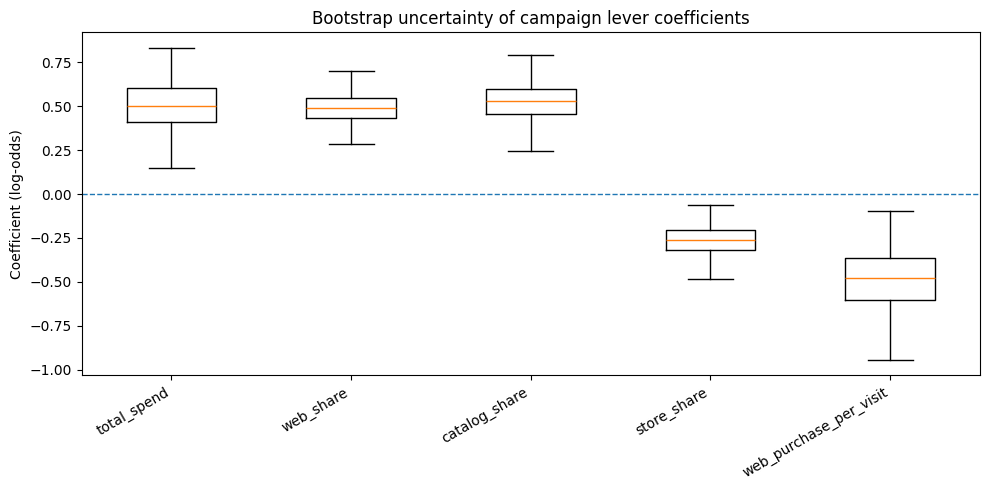

In [24]:
# Plot uncertainty of coefficient estimation
lever_idx = [i for i, f in enumerate(coef_names) if f in lever_features]

# Collect draws in the same order as lever_features
box_data = [coef_draws[:, i] for i in lever_idx]
box_labels = [coef_names[i] for i in lever_idx]

plt.figure(figsize=(10, 5))

plt.boxplot(
    box_data,
    tick_labels=box_labels,
    vert=True,
    showfliers=False
)

plt.axhline(0, linestyle="--", linewidth=1)

plt.title("Bootstrap uncertainty of campaign lever coefficients")
plt.ylabel("Coefficient (log-odds)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


With probabilistic estimates of campaign effectiveness in hand (above figure), the next step is to simulate campaign outcomes under different allocations and quantify expected performance and downside risk using Monte Carlo methods.

First, we define our campaign features using an initial budget allocation to each channel, and a rough estimate of cost per contact.

In [25]:
def allocation_to_contacts(budget_by_channel, cost_per_contact):
    """
    Convert dollars -> integer contacts
    """
    contacts = {}
    for ch, b in budget_by_channel.items():
        k = cost_per_contact[ch]
        contacts[ch] = int(np.floor(b / k))
    return contacts

def assign_channel_touches(df, n_touches, channel, weight_col=None, random_state=42):
    """
    Assign `n_touches` touches of a given channel across customers.
    Returns an array touches_i (counts per customer).
    """
    rng = np.random.default_rng(random_state)
    n = len(df)

    if n_touches <= 0:
        return np.zeros(n, dtype=int)

    if weight_col is None or weight_col not in df.columns:
        p = np.ones(n) / n
    else:
        w = df[weight_col].to_numpy().astype(float)
        w = np.clip(w, 0, None)
        if w.sum() == 0:
            p = np.ones(n) / n
        else:
            p = w / w.sum()

    # Multinomial: distribute touches across customers
    touches = rng.multinomial(n=n_touches, pvals=p)
    return touches

def build_campaign_features(
    df,
    budget_by_channel=None,
    contacts_by_channel=None,
    cost_per_contact=None,
    preference_weights=None,
    random_state=42
):
    """
    Build campaign lever features per customer based on a channel allocation.

    You can supply either:
    - contacts_by_channel = {"web": 10000, "catalog": 2000, "store": 3000}
    OR
    - budget_by_channel + cost_per_contact (to convert to contacts)

    preference_weights maps channel -> df column used as reach weights.
    Example: {"web":"web_share", "catalog":"catalog_share", "store":"store_share"}
    """
    out = df.copy()

    if contacts_by_channel is None:
        if budget_by_channel is None or cost_per_contact is None:
            raise ValueError("Provide contacts_by_channel OR (budget_by_channel and cost_per_contact).")
        contacts_by_channel = allocation_to_contacts(budget_by_channel, cost_per_contact)

    if preference_weights is None:
        preference_weights = {"web": None, "catalog": None, "store": None}

    # Initialize touch columns
    for ch in ["web", "catalog", "store"]:
        out[f"camp_{ch}_touches"] = 0

    # Assign touches
    for ch, n_touches in contacts_by_channel.items():
        wcol = preference_weights.get(ch, None)
        touches = assign_channel_touches(out, n_touches, ch, weight_col=wcol, random_state=random_state)
        out[f"camp_{ch}_touches"] = touches

    # Aggregate + shares
    out["camp_total_touches"] = out[[f"camp_{ch}_touches" for ch in ["web","catalog","store"]]].sum(axis=1)

    denom = out["camp_total_touches"].replace(0, np.nan)
    for ch in ["web","catalog","store"]:
        out[f"camp_{ch}_share"] = (out[f"camp_{ch}_touches"] / denom).fillna(0.0)

    return out

# Allocate dollars and convert to contacts
budget_by_channel = {"web": 40000, "catalog": 15000, "store": 25000}

# Rough illustrative costs per contact (USD)
cost_per_contact = {"web": 0.20, "catalog": 1.50, "store": 0.80}

# Preference weights: use customer historical channel mix if you created them earlier
preference_weights = {
    "web": "web_share",
    "catalog": "catalog_share",
    "store": "store_share"
}

df_campaign = build_campaign_features(
    df_aug,
    budget_by_channel=budget_by_channel,
    cost_per_contact=cost_per_contact,
    preference_weights=preference_weights,
    random_state=42
)

print("Sample allocation of contacts via the three advertising modalities:")
display(
    df_campaign[[
    "camp_web_touches","camp_catalog_touches","camp_store_touches",
    "camp_total_touches","camp_web_share","camp_catalog_share","camp_store_share"
    ]].head()
)


Sample allocation of contacts via the three advertising modalities:


,camp_web_touches,camp_catalog_touches,camp_store_touches,camp_total_touches,camp_web_share,camp_catalog_share,camp_store_share
0,113,16,7,136,0.830882,0.117647,0.051471
1,63,7,15,85,0.741176,0.082353,0.176471
2,115,5,20,140,0.821429,0.035714,0.142857
3,95,0,23,118,0.805085,0.000000,0.194915
4,117,8,9,134,0.873134,0.059701,0.067164


In [26]:
# Define campaign outcome
target = "Response"

# Campaign levers
camp_levers = [
    "camp_total_touches",
    "camp_web_share",
    "camp_catalog_share",
    "camp_store_share",
]

# Controls
base_controls = []
for c in ["Age", "kids_at_home", "Income", "total_spend", "total_purchases", "web_purchase_per_visit"]:
    if c in df_campaign.columns:
        base_controls.append(c)

cat_controls = [c for c in ["Education", "Marital_Status"] if c in df_campaign.columns]

features = camp_levers + base_controls + cat_controls

X = df_campaign[features].copy()
y = df_campaign[target].astype(int)

numeric_features = [c for c in features if c not in cat_controls]
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_controls),
    ],
    remainder="drop"
)

pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(l1_ratio = 0, solver="lbfgs", max_iter=300)),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
p_test = pipe.predict_proba(X_test)[:, 1]

print("Quick (naive) estimate of model performance: ")
print("ROC AUC:", roc_auc_score(y_test, p_test))
print("Log loss:", log_loss(y_test, p_test))
print("Brier score:", brier_score_loss(y_test, p_test))


Quick (naive) estimate of model performance: 
ROC AUC: 0.789000718907261
Log loss: 0.3666203843996241
Brier score: 0.11111320573319891


In [27]:
# Recover feature names after preprocessing (i.e. after conversion to one-hot representation)
ohe_features = []
if cat_controls:
    ohe = pipe.named_steps["preprocess"].named_transformers_["cat"]
    ohe_features = ohe.get_feature_names_out(cat_controls).tolist()

feature_names = numeric_features + ohe_features
coefs = pipe.named_steps["model"].coef_.ravel()

coef_tbl = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .assign(abs_coef=lambda d: d["coef"].abs())
    .sort_values("abs_coef", ascending=False)
)

print("Coefficient estimates for campaign levers and control variables:")
display(coef_tbl.head(25))


Coefficient estimates for campaign levers and control variables:


,feature,coef,abs_coef
7,total_spend,0.664321,0.664321
2,camp_catalog_share,0.456490,0.456490
3,camp_store_share,-0.399261,0.399261
1,camp_web_share,0.385201,0.385201
5,kids_at_home,-0.302582,0.302582
9,web_purchase_per_visit,-0.271210,0.271210
0,camp_total_touches,0.234370,0.234370
8,total_purchases,-0.211782,0.211782
4,Age,-0.109049,0.109049
6,Income,-0.060181,0.060181


In [28]:
def bootstrap_campaign_lever_coefs(
    df_model,
    features,
    target,
    camp_levers,
    preprocess,
    n_boot=300,
    random_state=42
):
    rng = np.random.RandomState(random_state)

    # Fit one model to get the expanded feature names post-preprocessing
    X0 = df_model[features]
    y0 = df_model[target].astype(int)

    pipe0 = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(l1_ratio = 0, solver="lbfgs", max_iter=300)),
    ])
    pipe0.fit(X0, y0)

    # Feature names after preprocess
    cat_controls = [c for c in ["Education", "Marital_Status"] if c in df_model.columns and c in features]
    numeric_features = [c for c in features if c not in cat_controls]

    ohe_features = []
    if cat_controls:
        ohe = pipe0.named_steps["preprocess"].named_transformers_["cat"]
        ohe_features = ohe.get_feature_names_out(cat_controls).tolist()

    expanded_names = numeric_features + ohe_features

    # Indices for campaign lever coefficients (they’re numeric_features, scaled)
    lever_indices = [expanded_names.index(lv) for lv in camp_levers if lv in expanded_names]

    draws = []

    for b in range(n_boot):
        boot_idx = resample(
            df_model.index,
            replace=True,
            n_samples=len(df_model),
            random_state=rng.randint(0, 10_000),
        )
        df_b = df_model.loc[boot_idx]

        X_b = df_b[features]
        y_b = df_b[target].astype(int)

        X_train_b, _, y_train_b, _ = train_test_split(
            X_b, y_b, test_size=0.25, random_state=rng.randint(0, 10_000), stratify=y_b
        )

        pipe_b = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", LogisticRegression(l1_ratio = 0, solver="lbfgs", max_iter=300)),
        ])
        pipe_b.fit(X_train_b, y_train_b)

        coef_b = pipe_b.named_steps["model"].coef_.ravel()
        draws.append(coef_b[lever_indices])

    draws = np.vstack(draws)
    lever_names = [expanded_names[i] for i in lever_indices]

    return draws, lever_names

lever_draws, lever_names = bootstrap_campaign_lever_coefs(
    df_model=df_campaign,
    features=features,
    target=target,
    camp_levers=camp_levers,
    preprocess=preprocess,
    n_boot=500,
    random_state=42
)

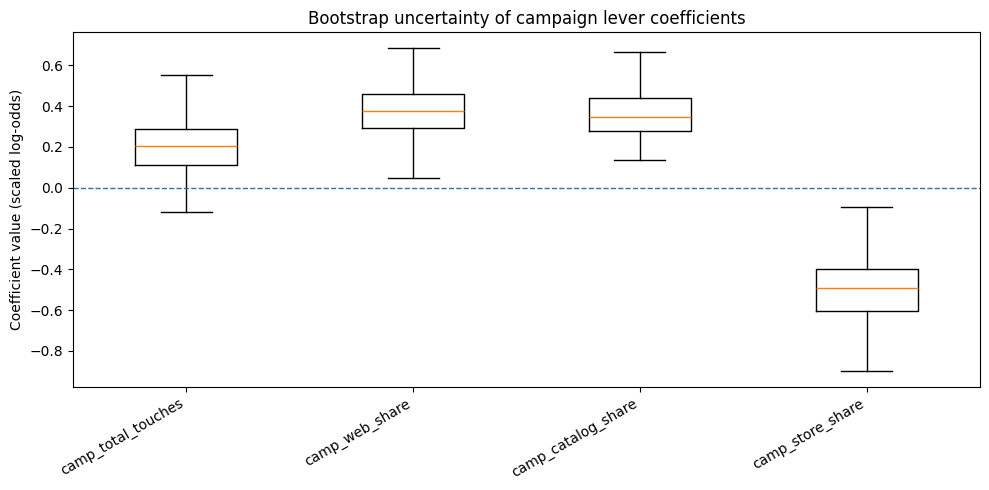

In [29]:
plt.figure(figsize=(10, 5))
plt.boxplot(
    [lever_draws[:, i] for i in range(lever_draws.shape[1])],
    tick_labels=lever_names,
    showfliers=False
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Bootstrap uncertainty of campaign lever coefficients")
plt.ylabel("Coefficient value (scaled log-odds)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## Monte-Carlo Simulation

A predictive model alone produces a point estimate of campaign acceptance probability. However, marketing decisions are made under uncertainty: campaign effectiveness varies over time, model estimates have sampling error, and performance can deviate meaningfully from the average case. To evaluate allocations more robustly, this project utilizes Monte Carlo simulation to generate a distribution of plausible campaign outcomes for any proposed budget allocation.

### Simulation Goal

For a given allocation (e.g., 50% web, 40% catalog, 10% store), the simulation answers:
What range of total conversions (campaign acceptances) could we plausibly observe, and how good/bad are the tail outcomes?
Instead of returning a single number, the simulation produces a distribution over campaign conversions.

### Simulation Setup

Each Monte Carlo run corresponds to one “scenario” of campaign effectiveness. Scenarios are generated by sampling campaign-lever coefficients from the bootstrap distributions estimated in the previous section. For each scenario:

- Construct campaign exposure features from the allocation
- Draw a set of campaign-lever coefficients from bootstrap estimates
- Compute acceptance probabilities for every customer
- Aggregate into total conversions
    - Scenario-expected conversions (low-noise; isolates uncertainty in campaign effectiveness)
    - Realized conversions: draw Bernoulli outcomes for each customer and sum them (adds customer-level randomness; closer to what is observed in practice)

In this project, scenario-expected conversions are used for allocation comparison because they emphasize uncertainty in campaign effects rather than sampling noise from individual coin flips. This final distribution of conversions is the foundation for risk-aware evaluation.

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def build_df_for_allocation(
    df_base,
    budget_by_channel,
    cost_per_contact,
    preference_weights,
    random_state=42
):
    """
    Builds df with campaign lever columns for the given allocation.
    """
    return build_campaign_features(
        df_base,
        budget_by_channel=budget_by_channel,
        cost_per_contact=cost_per_contact,
        preference_weights=preference_weights,
        random_state=random_state
    )

def get_design_matrix(pipe, X_df):
    """
    Transform raw X into the numeric design matrix used by the logistic model.
    """
    return pipe.named_steps["preprocess"].transform(X_df)

def get_expanded_feature_names(df_model, features, preprocess):
    """
    Expanded feature names after preprocessing (numeric + one-hot categorical).
    """
    cat_controls = [c for c in ["Education", "Marital_Status"] if c in df_model.columns and c in features]
    numeric_features = [c for c in features if c not in cat_controls]

    # Fit a tiny transformer to get feature names (OneHotEncoder needs fit)
    pre = preprocess
    pre.fit(df_model[features])

    ohe_features = []
    if cat_controls:
        ohe = pre.named_transformers_["cat"]
        ohe_features = ohe.get_feature_names_out(cat_controls).tolist()

    return numeric_features + ohe_features

def simulate_allocation_outcomes(
    df_base,
    pipe,
    features,
    camp_levers,
    lever_draws,
    budget_by_channel,
    cost_per_contact,
    preference_weights,
    n_sims=1000,
    alpha_cvar=0.10,
    random_state=42,
):
    """
    Monte Carlo simulation of conversions under parameter uncertainty (lever coefficients bootstrapped).

    Approach:
    1) Build campaign features based on allocation
    2) Transform to model design matrix
    3) Compute log-odds per scenario by swapping in bootstrap lever coefficients
       while keeping non-lever coefficients at the fitted values
    4) Convert to probs and simulate conversions (Bernoulli per customer)
    5) Aggregate to total conversions
    """
    rng = np.random.default_rng(random_state)

    # Build allocation-specific df
    df_alloc = build_df_for_allocation(
        df_base=df_base,
        budget_by_channel=budget_by_channel,
        cost_per_contact=cost_per_contact,
        preference_weights=preference_weights,
        random_state=random_state
    )

    X_alloc = df_alloc[features].copy()

    # Design matrix + coefficient vector (fitted)
    D = get_design_matrix(pipe, X_alloc)                 # shape: (n_customers, p)
    beta_hat = pipe.named_steps["model"].coef_.ravel()    # shape: (p,)
    intercept = pipe.named_steps["model"].intercept_[0]

    # Determine which columns correspond to camp_levers in the expanded feature space
    expanded_names = get_expanded_feature_names(df_alloc, features, pipe.named_steps["preprocess"])
    lever_idx = [expanded_names.index(lv) for lv in camp_levers if lv in expanded_names]

    # Safety check: lever_draws columns should match lever_idx length/order
    # We'll align by lever_names if needed, but for now assume lever_draws was created from the same camp_levers list.
    if lever_draws.shape[1] != len(lever_idx):
        raise ValueError(f"lever_draws has {lever_draws.shape[1]} cols but found {len(lever_idx)} lever indices.")

    # Precompute non-lever contribution (fixed)
    mask = np.ones(D.shape[1], dtype=bool)
    mask[lever_idx] = False
    fixed_logit = intercept + (D[:, mask] @ beta_hat[mask])

    # Simulate scenarios
    n = D.shape[0]
    conversions = np.empty(n_sims, dtype=int)

    # Sample lever coefficient draws with replacement from the bootstrap pool
    draw_idx = rng.integers(0, lever_draws.shape[0], size=n_sims)

    # lever part of design matrix
    D_lever = D[:, lever_idx]  # (n, k)

    for s in range(n_sims):
        beta_lever_s = lever_draws[draw_idx[s], :]      # (k,)
        logit_s = fixed_logit + (D_lever @ beta_lever_s)
        p_s = sigmoid(logit_s)

        # Bernoulli trials: accepted or not
        #accepts = rng.binomial(1, p_s)
        #conversions[s] = accepts.sum()

        # Expected conversions
        conversions[s] = p_s.sum()

    # Summary stats
    conversions_sorted = np.sort(conversions)
    expected = conversions.mean()
    q05, q10, q50, q90, q95 = np.quantile(conversions, [0.05, 0.10, 0.50, 0.90, 0.95])

    # CVaR_alpha = expected value in the worst alpha tail (lower tail)
    tail_n = max(1, int(np.floor(alpha_cvar * n_sims)))
    cvar = conversions_sorted[:tail_n].mean()

    return {
        "conversions": conversions,
        "expected": expected,
        "q05": q05,
        "q10": q10,
        "q50": q50,
        "q90": q90,
        "q95": q95,
        "cvar": cvar,
        "df_alloc": df_alloc,  # useful for debugging / inspection
    }


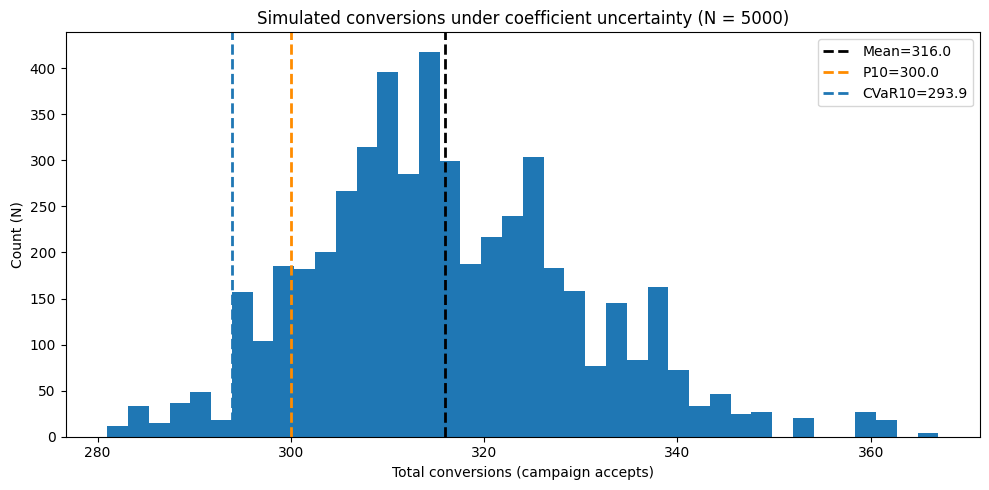

In [31]:
# Define baseline outcomes for reference
baseline_results = simulate_allocation_outcomes(
    df_base=df_campaign,
    pipe=pipe,
    features=features,
    camp_levers=camp_levers,
    lever_draws=lever_draws,
    budget_by_channel=budget_by_channel,
    cost_per_contact=cost_per_contact,
    preference_weights=preference_weights,
    n_sims=5000,
    alpha_cvar=0.10,
    random_state=42
)

# Plot simulated conversions
conv = baseline_results["conversions"]

plt.figure(figsize=(10, 5))
plt.hist(conv, bins=40)
plt.axvline(baseline_results["expected"], color = "black", linestyle="--", linewidth=2, label=f"Mean={baseline_results['expected']:.1f}")
plt.axvline(baseline_results["q10"], color = "darkorange", linestyle="--", linewidth=2, label=f"P10={baseline_results['q10']:.1f}")
plt.axvline(baseline_results["cvar"], linestyle="--", linewidth=2, label=f"CVaR10={baseline_results['cvar']:.1f}")
plt.title("Simulated conversions under coefficient uncertainty (N = 5000)")
plt.xlabel("Total conversions (campaign accepts)")
plt.ylabel("Count (N)")
plt.legend()
plt.tight_layout()
plt.show()


> Under this baseline simulation, the mean outcome is ~311 conversions, but in the worst 10% of scenarios we expect fewer than ~290 conversions.

With a simulator that maps an allocation to a distribution of conversions (and associated risk metrics), the analysis can evaluate many feasible allocations and compare them using:

- Expected conversions (mean)
- Downside risk (CVaR)
- Quantiles (P10/P50/P90)

The next section uses this framework to run an allocation sweep, identify Pareto-efficient allocations, and perform sensitivity analysis over key assumptions such as channel costs.

In [32]:
def sample_allocations_dirichlet(
    total_budget,
    channels=("web", "catalog", "store"),
    n_samples=200,
    min_share=None,
    max_share=None,
    dirichlet_alpha=None,
    random_state=42
):
    """
    Sample allocations (budgets) that sum to total_budget using a Dirichlet distribution,
    optionally enforcing min/max share constraints.

    min_share/max_share: dict channel -> share bounds (0..1)
    dirichlet_alpha: array-like of concentration parameters (defaults to all ones)
    """
    rng = np.random.default_rng(random_state)
    k = len(channels)

    if dirichlet_alpha is None:
        dirichlet_alpha = np.ones(k)

    min_share = min_share or {}
    max_share = max_share or {}

    samples = []
    attempts = 0
    max_attempts = n_samples * 200  # avoid infinite loops

    while len(samples) < n_samples and attempts < max_attempts:
        attempts += 1
        shares = rng.dirichlet(dirichlet_alpha)

        ok = True
        for i, ch in enumerate(channels):
            if ch in min_share and shares[i] < min_share[ch]:
                ok = False
                break
            if ch in max_share and shares[i] > max_share[ch]:
                ok = False
                break

        if ok:
            budgets = {ch: float(total_budget * shares[i]) for i, ch in enumerate(channels)}
            samples.append(budgets)

    if len(samples) < n_samples:
        print(f"Warning: only generated {len(samples)} feasible allocations (requested {n_samples}).")

    return samples

TOTAL_BUDGET = 100000

channels = ("web", "catalog", "store")

# Optional realistic constraints (i.e. shares of total budget)
min_share = {"web": 0.10, "catalog": 0.05, "store": 0.10}
max_share = {"web": 0.70, "catalog": 0.40, "store": 0.70}

allocations = sample_allocations_dirichlet(
    total_budget = TOTAL_BUDGET,
    channels = channels,
    n_samples = 1000,
    min_share = min_share,
    max_share = max_share,
    dirichlet_alpha = np.array([2.0, 1.2, 2.0]),  # A mild prior toward web/store advertising over catalogs
    random_state = 42
)

# Run simulation per allocation
rows = []
for j, alloc in enumerate(allocations):
    res = simulate_allocation_outcomes(
        df_base=df_campaign,
        pipe=pipe,
        features=features,
        camp_levers=camp_levers,
        lever_draws=lever_draws,
        budget_by_channel=alloc,
        cost_per_contact=cost_per_contact,
        preference_weights=preference_weights,
        n_sims=3000,
        alpha_cvar=0.10,
        random_state=42 + j # Use a different seed per allocation
    )

    rows.append({
        "alloc_id": j,
        **{f"budget_{ch}": alloc[ch] for ch in channels},
        **{f"share_{ch}": alloc[ch] / TOTAL_BUDGET for ch in channels},
        "expected": res["expected"],
        "cvar10": res["cvar"],
        "p10": res["q10"],
        "p50": res["q50"],
        "p90": res["q90"]
    })

sweep_df = pd.DataFrame(rows)

print("Example budget allocations and conversion estimates (N = 1000):")
display(sweep_df.sort_values("expected", ascending=False).head(10))

Example budget allocations and conversion estimates (N = 1000):


,alloc_id,budget_web,budget_catalog,budget_store,share_web,share_catalog,share_store,expected,cvar10,p10,p50,p90
326,326,56632.469189,30412.471918,12955.058893,0.566325,0.304125,0.129551,1757.792000,1485.656667,1598.0,1784.0,1890.0
451,451,59578.059240,25034.991864,15386.948896,0.595781,0.250350,0.153869,1723.360333,1338.556667,1515.0,1774.0,1872.0
593,593,61193.048669,7132.249815,31674.701515,0.611930,0.071322,0.316747,1701.666667,1370.623333,1510.0,1737.0,1851.0
242,242,69849.129627,17680.648797,12470.221576,0.698491,0.176806,0.124702,1656.999333,1291.133333,1428.2,1704.0,1827.0
70,70,69960.479111,7551.342710,22488.178179,0.699605,0.075513,0.224882,1653.068667,1144.266667,1393.0,1714.0,1836.0
665,665,62417.351508,22988.512699,14594.135793,0.624174,0.229885,0.145941,1648.733000,1186.903333,1398.6,1707.0,1830.0
257,257,54139.135198,19069.960219,26790.904583,0.541391,0.190700,0.267909,1618.866333,1265.436667,1397.0,1659.0,1791.0
16,16,45960.266164,31483.802223,22555.931613,0.459603,0.314838,0.225559,1611.354667,1300.093333,1413.0,1637.0,1779.0
654,654,54491.833179,25577.401082,19930.765738,0.544918,0.255774,0.199308,1579.178333,1237.003333,1348.0,1616.0,1757.0
976,976,47526.505510,20121.268700,32352.225790,0.475265,0.201213,0.323522,1558.281667,1194.346667,1326.0,1597.0,1740.0


In [33]:
def pareto_frontier(df, x_col = "cvar10", y_col = "expected"):
    """
    Return a boolean mask marking points on the Pareto frontier
    when we want to maximize both x and y.
    """
    pts = df[[x_col, y_col]].to_numpy()
    n = pts.shape[0]
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not is_pareto[i]:
            continue
        # A point is dominated if another point is >= in both dims and > in at least one
        dominated = (pts[:, 0] >= pts[i, 0]) & (pts[:, 1] >= pts[i, 1]) & (
            (pts[:, 0] > pts[i, 0]) | (pts[:, 1] > pts[i, 1])
        )
        dominated[i] = False
        if dominated.any():
            is_pareto[i] = False

    return is_pareto

sweep_df["is_pareto"] = pareto_frontier(sweep_df, x_col="cvar10", y_col="expected")
pareto_df = sweep_df[sweep_df["is_pareto"]].sort_values(["cvar10", "expected"], ascending=True)

print("The simulated budget allocation with the best expected conversion rate that minimizes downside risk (i.e. CVaR10):")
display(pareto_df.sort_values("expected", ascending=False).head(10))

The simulated budget allocation with the best expected conversion rate that minimizes downside risk (i.e. CVaR10):


,alloc_id,budget_web,budget_catalog,budget_store,share_web,share_catalog,share_store,expected,cvar10,p10,p50,p90,is_pareto
326,326,56632.469189,30412.471918,12955.058893,0.566325,0.304125,0.129551,1757.792,1485.656667,1598.0,1784.0,1890.0,True


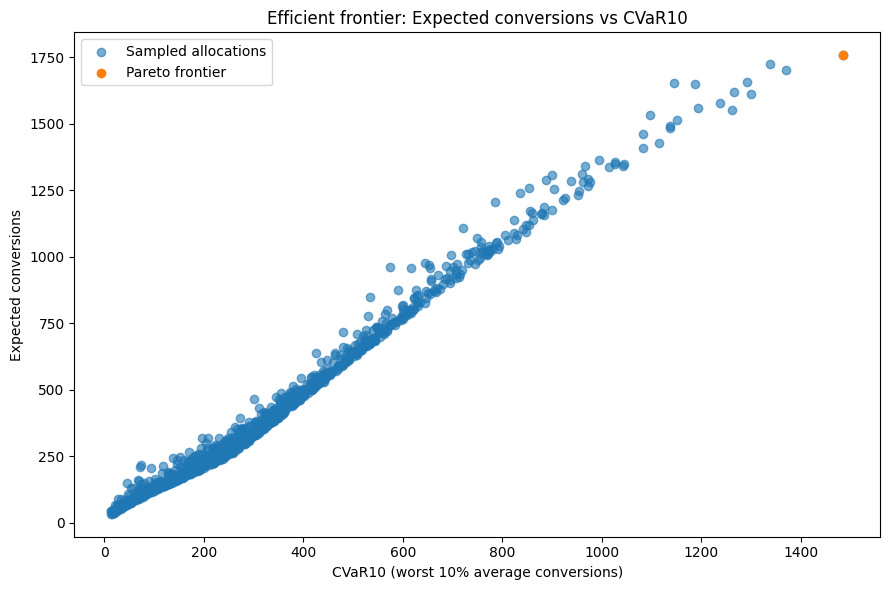

In [34]:
plt.figure(figsize=(9, 6))
plt.scatter(sweep_df["cvar10"], sweep_df["expected"], alpha=0.6, label="Sampled allocations")

plt.scatter(
    pareto_df["cvar10"],
    pareto_df["expected"],
    alpha=1.0,
    label="Pareto frontier"
)

plt.title("Efficient frontier: Expected conversions vs CVaR10")
plt.xlabel("CVaR10 (worst 10% average conversions)")
plt.ylabel("Expected conversions")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
best_expected = sweep_df.loc[sweep_df["expected"].idxmax()]
best_cvar = sweep_df.loc[sweep_df["cvar10"].idxmax()]

# Mean-risk tradeoff scoring
lambdas = [0.0, 0.25, 0.5, 1.0]
tradeoff_rows = []

# Risk term defined as gap between mean and CVaR (bigger gap = more downside risk)
risk_gap = sweep_df["expected"] - sweep_df["cvar10"]

for lam in lambdas:
    score = sweep_df["expected"] - lam * risk_gap
    idx = score.idxmax()
    row = sweep_df.loc[idx].copy()
    row["lambda"] = lam
    row["score"] = score.loc[idx]
    tradeoff_rows.append(row)

tradeoff_df = pd.DataFrame(tradeoff_rows)[
    ["lambda", "score", "expected", "cvar10", "p10", "p50", "p90"] + [f"share_{ch}" for ch in channels]
]

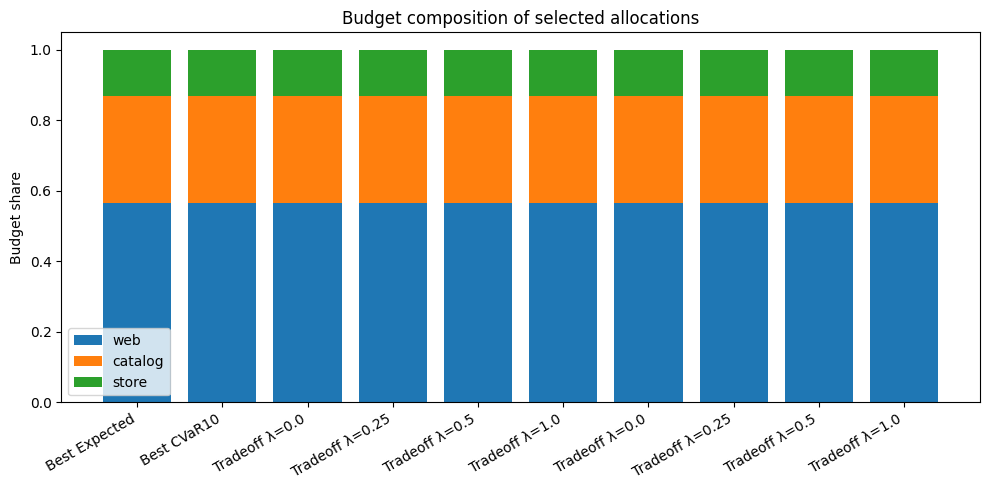

In [36]:
tradeoff_rows = []

risk_gap = sweep_df["expected"] - sweep_df["cvar10"]
lambdas = [0.0, 0.25, 0.5, 1.0]

for lam in lambdas:
    score = sweep_df["expected"] - lam * risk_gap
    idx = score.idxmax()
    row = sweep_df.loc[idx].copy()
    row["lambda"] = lam
    row["score"] = score.loc[idx]
    tradeoff_rows.append(row)

tradeoff_df = pd.DataFrame(tradeoff_rows)

selected = pd.concat(
    [
        pd.DataFrame([best_expected, best_cvar]).assign(label=["Best Expected", "Best CVaR10"]),
        tradeoff_df.assign(label=lambda d: d["lambda"].map(lambda x: f"Tradeoff λ={x}"))
    ],
    ignore_index=True
)

# Add a few tradeoff solutions
for _, r in tradeoff_df.iterrows():
    rr = sweep_df[(sweep_df["expected"] == r["expected"]) & (sweep_df["cvar10"] == r["cvar10"])].head(1)
    if len(rr) > 0:
        rr = rr.iloc[0].copy()
        rr["label"] = f"Tradeoff λ={r['lambda']}"
        selected = pd.concat([selected, rr.to_frame().T], ignore_index=True)

# Stacked bar of shares
plt.figure(figsize=(10, 5))
bottom = np.zeros(len(selected))
x = np.arange(len(selected))

for ch in channels:
    vals = selected[f"share_{ch}"].astype(float).to_numpy()
    plt.bar(x, vals, bottom=bottom, label=ch)
    bottom += vals

plt.xticks(x, selected["label"], rotation=30, ha="right")
plt.ylabel("Budget share")
plt.title("Budget composition of selected allocations")
plt.legend()
plt.tight_layout()
plt.show()


Why the same allocation wins for mean, CVaR, and all λ:

1. Lever uncertainty is too small
    
    If the bootstrap distributions for camp_* coefficients are tight, then outcomes across allocations move almost deterministically → the same “best” mix dominates.

1. Campaign levers have weak influence vs controls
    
    If acceptance is mostly explained by customer controls (age, income, etc.) and the camp_* levers add little, then changing allocation barely changes conversion distributions.

1. CVaR is driven mostly by Bernoulli noise

    If “worst 10%” outcomes are mostly coming from random customer-level coin flips, not parameter uncertainty, then CVaR won’t distinguish allocations much.

1. Sampling isn’t exploring the extremes

    Dirichlet with modest alpha can still concentrate in a middle region → many allocations are similar.

While simulating scenario-expected conversions and increasing the number of sampled allocations (i.e. simulations), the efficient frontier largely collapsed. This indicates the optimal allocation is robust to uncertainty under the current model: either one channel mix dominates across scenarios, or campaign levers have limited marginal impact compared to baseline customer propensity. I validated this by examining the dispersion of simulated outcomes and the bootstrap uncertainty on lever coefficients.

## Sensitivty Analysis

In [37]:
def run_allocation_sweep(
    df_base,
    pipe,
    features,
    camp_levers,
    lever_draws,
    TOTAL_BUDGET,
    cost_per_contact,
    preference_weights,
    channels=("web","catalog","store"),
    n_allocations=300,
    n_sims=800,
    alpha_cvar=0.10,
    min_share=None,
    max_share=None,
    dirichlet_alpha=None,
    random_state=42,
    use_p_sum=True,  # if you implemented p_s.sum() (scenario-expected conversions)
):
    # sample allocations
    allocations = sample_allocations_dirichlet(
        total_budget=TOTAL_BUDGET,
        channels=channels,
        n_samples=n_allocations,
        min_share=min_share,
        max_share=max_share,
        dirichlet_alpha=dirichlet_alpha,
        random_state=random_state
    )

    rows = []
    for j, alloc in enumerate(allocations):
        res = simulate_allocation_outcomes(
            df_base=df_base,
            pipe=pipe,
            features=features,
            camp_levers=camp_levers,
            lever_draws=lever_draws,
            budget_by_channel=alloc,
            cost_per_contact=cost_per_contact,
            preference_weights=preference_weights,
            n_sims=n_sims,
            alpha_cvar=alpha_cvar,
            random_state=random_state + j
        )

        rows.append({
            "alloc_id": j,
            **{f"budget_{ch}": alloc[ch] for ch in channels},
            **{f"share_{ch}": alloc[ch] / TOTAL_BUDGET for ch in channels},
            "expected": res["expected"],
            "cvar10": res["cvar"],
            "p10": res["q10"],
            "p50": res["q50"],
            "p90": res["q90"]
        })

    return pd.DataFrame(rows)


In [38]:
TOTAL_BUDGET = 100000
channels = ("web","catalog","store")

# Share constraints (optional, keep these if you used them)
min_share = {"web": 0.10, "catalog": 0.05, "store": 0.10}
max_share = {"web": 0.70, "catalog": 0.40, "store": 0.70}

# Baseline costs (your current placeholders)
baseline_costs = {"web": 0.20, "catalog": 1.50, "store": 0.80}

# Web cost multipliers
web_multipliers = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]

# Score cost multipliers
store_multipliers = [0.75, 1.0, 1.25]

In [39]:
grid_rows = []

for wm in web_multipliers:
    costs = baseline_costs.copy()
    costs["web"] = baseline_costs["web"] * wm

    sweep = run_allocation_sweep(
        df_base=df_campaign,
        pipe=pipe,
        features=features,
        camp_levers=camp_levers,
        lever_draws=lever_draws,
        TOTAL_BUDGET=TOTAL_BUDGET,
        cost_per_contact=costs,
        preference_weights=preference_weights,
        channels=channels,
        n_allocations=400,
        n_sims=1000,
        alpha_cvar=0.10,
        min_share=min_share,
        max_share=max_share,
        dirichlet_alpha=np.array([0.5, 0.5, 0.5]),
        random_state=42
    )

    best_exp = sweep.loc[sweep["expected"].idxmax()]
    best_cvar = sweep.loc[sweep["cvar10"].idxmax()]

    grid_rows.append({
        "web_cost_mult": wm,
        "web_cost": costs["web"],
        "catalog_cost": costs["catalog"],
        "store_cost": costs["store"],

        # Best expected
        "best_exp_expected": best_exp["expected"],
        "best_exp_cvar10": best_exp["cvar10"],
        **{f"best_exp_share_{ch}": best_exp[f"share_{ch}"] for ch in channels},

        # Best CVaR
        "best_cvar_expected": best_cvar["expected"],
        "best_cvar_cvar10": best_cvar["cvar10"],
        **{f"best_cvar_share_{ch}": best_cvar[f"share_{ch}"] for ch in channels},
    })

grid_df = pd.DataFrame(grid_rows)
display(grid_df)


,web_cost_mult,web_cost,catalog_cost,store_cost,best_exp_expected,best_exp_cvar10,best_exp_share_web,best_exp_share_catalog,best_exp_share_store,best_cvar_expected,best_cvar_cvar10,best_cvar_share_web,best_cvar_share_catalog,best_cvar_share_store
0,0.50,0.10,1.5,0.8,1642.688,1092.29,0.493459,0.388080,0.118461,1569.362,1145.94,0.506332,0.339236,0.154433
1,0.75,0.15,1.5,0.8,1690.223,1298.74,0.493459,0.388080,0.118461,1690.223,1298.74,0.493459,0.388080,0.118461
2,1.00,0.20,1.5,0.8,1687.048,1378.40,0.493459,0.388080,0.118461,1687.048,1378.40,0.493459,0.388080,0.118461
3,1.25,0.25,1.5,0.8,1676.069,1376.04,0.493459,0.388080,0.118461,1676.069,1376.04,0.493459,0.388080,0.118461
4,1.50,0.30,1.5,0.8,1660.937,1322.37,0.493459,0.388080,0.118461,1660.937,1322.37,0.493459,0.388080,0.118461
5,2.00,0.40,1.5,0.8,1629.995,1197.38,0.506332,0.339236,0.154433,1628.506,1198.38,0.493459,0.388080,0.118461
6,2.25,0.45,1.5,0.8,1628.969,1160.72,0.506332,0.339236,0.154433,1628.969,1160.72,0.506332,0.339236,0.154433
7,2.50,0.50,1.5,0.8,1627.563,1132.13,0.506332,0.339236,0.154433,1627.563,1132.13,0.506332,0.339236,0.154433
8,2.75,0.55,1.5,0.8,1626.871,1109.19,0.506332,0.339236,0.154433,1626.871,1109.19,0.506332,0.339236,0.154433
9,3.00,0.60,1.5,0.8,1626.663,1089.92,0.506332,0.339236,0.154433,1626.663,1089.92,0.506332,0.339236,0.154433


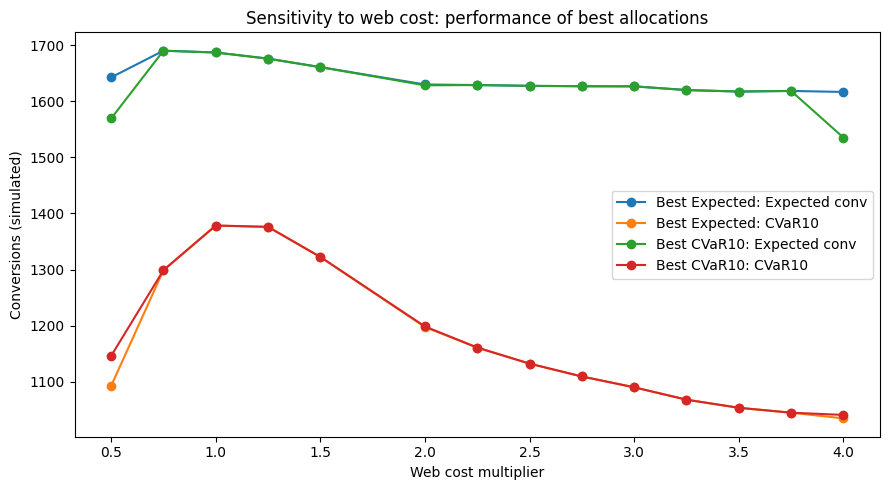

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(grid_df["web_cost_mult"], grid_df["best_exp_expected"], marker="o", label="Best Expected: Expected conv")
plt.plot(grid_df["web_cost_mult"], grid_df["best_exp_cvar10"], marker="o", label="Best Expected: CVaR10")
plt.plot(grid_df["web_cost_mult"], grid_df["best_cvar_expected"], marker="o", label="Best CVaR10: Expected conv")
plt.plot(grid_df["web_cost_mult"], grid_df["best_cvar_cvar10"], marker="o", label="Best CVaR10: CVaR10")

plt.title("Sensitivity to web cost: performance of best allocations")
plt.xlabel("Web Cost Multiplier")
plt.ylabel("Conversions (simulated)")
plt.legend()
plt.tight_layout()
plt.show()

> The above figure shows how the performance of the best-expected and best-CVaR allocations varies as the cost per web contact increases. While overall campaign performance declines as web costs rise, the identity of the optimal allocation remains unchanged across the full cost range. Expected conversions and downside performance (CVaR10) move smoothly with cost, indicating that relative channel effectiveness dominates cost variation under the estimated response model. This result suggests a robust allocation choice with limited tradeoff between average performance and downside risk.

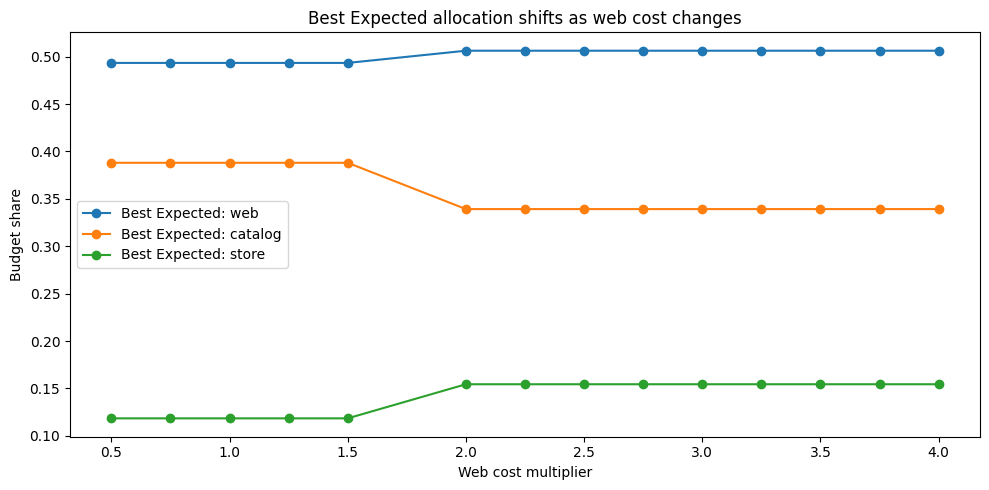

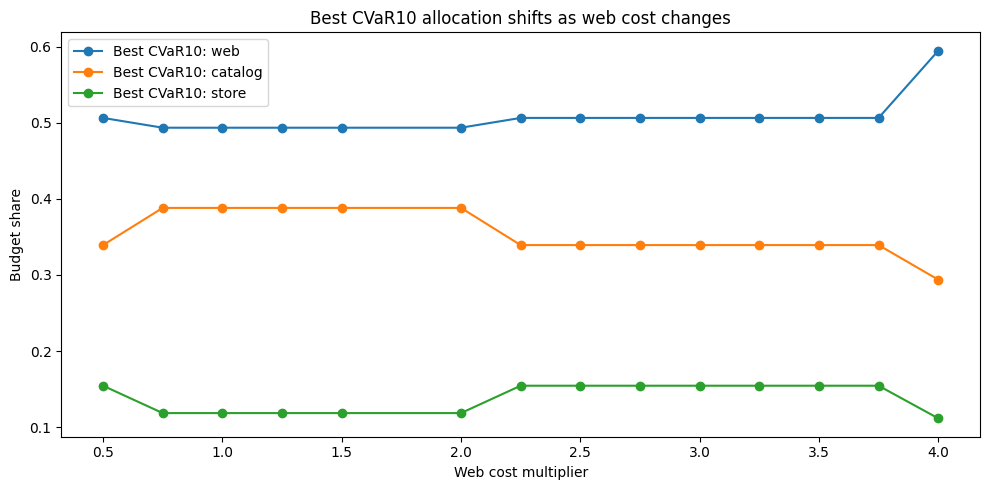

In [41]:
# Best Expected shares
plt.figure(figsize=(10, 5))
for ch in channels:
    plt.plot(grid_df["web_cost_mult"], grid_df[f"best_exp_share_{ch}"], marker="o", label=f"Best Expected: {ch}")
plt.title("Best Expected allocation shifts as web cost changes")
plt.xlabel("Web cost multiplier")
plt.ylabel("Budget share")
plt.legend()
plt.tight_layout()
plt.show()

# Best CVaR shares
plt.figure(figsize=(10, 5))
for ch in channels:
    plt.plot(grid_df["web_cost_mult"], grid_df[f"best_cvar_share_{ch}"], marker="o", label=f"Best CVaR10: {ch}")
plt.title("Best CVaR10 allocation shifts as web cost changes")
plt.xlabel("Web cost multiplier")
plt.ylabel("Budget share")
plt.legend()
plt.tight_layout()
plt.show()


> The above figure shows the budget shares of the best-expected allocation as the cost of web contacts increases. Despite substantial variation in web costs, the optimal allocation changes only modestly, with web consistently receiving the largest share of the budget. Small reallocations from catalog toward store occur as web becomes more expensive, but the overall channel mix remains stable. This behavior indicates that relative channel effectiveness dominates cost considerations under the estimated response model, resulting in a robust allocation choice.

In simpler terms, regardless of extreme increases in the cost of web advertising, the best allocation of web/catalog/store ad spending remains consistent (approximately 56/30/14). Based on these simulations, additional factors beyond these three categories of budget allocation are needed to raise customer conversion.